In [3]:
# Tecott Lab HCM Data
# HCMData_begin_script.py
# Chris Hillar, Dec 2015 (Tecott Lab: C. Hillar, G. Onnis, D. Rhea, L. Tecott)
# 
# Script for initial foray into HCM 16-Strain Mus musculus multi-modal data set

import numpy as np
from scipy.cluster.vq import whiten
%matplotlib inline

from data_utils import day_to_mouse_average, mouse_to_strain_average, total_time_rectangle_bins, pull_locom_tseries_subset, split_data_in_half_randomly
# from intervals import Intervals, binary_from_intervals


# Data set consists of 1921 Mouse days (22 hours each) from 170 Mice and 16 Strains:
strains = {0: 'C57BL6J', 1: 'BALB', 2: 'A', 3: '129S1', 4: 'DBA', 5: 'C3H', 
    6: 'AKR', 7: 'SWR', 8: 'SJL', 9: 'FVB',10: 'WSB', 11: 'CZECH', 12: 'CAST', 13: 'JF1', 14: 'MOLF', 15: 'SPRET'}
strain_colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), (1.0, 0.4980392156862745, 0.054901960784313725), (1.0, 0.7333333333333333, 0.47058823529411764), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.596078431372549, 0.8745098039215686, 0.5411764705882353), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.7725490196078432, 0.6901960784313725, 0.8352941176470589), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.7686274509803922, 0.611764705882353, 0.5803921568627451), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7803921568627451, 0.7803921568627451, 0.7803921568627451), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.8588235294117647, 0.8588235294117647, 0.5529411764705883), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529), (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

##########################
# Main Data Formats:
# (1) Features = 9 (feature type) x 1921 (mouse day) x 11 (2 hour time bin) numpy array
# (2) Raw Event Arrays of 6 types:
events = ['AS', 'F', 'IS', 'M_AS', 'M_IS', 'W']
# AS: Active State, F: Food, IS: Inactive State,
# M_AS: Move during AS, M_IS: Move during IS, W: Water
# with per 24 h breakdown:
# Strain: Mouse: Day: Event as a numpy array of dimension
#    (number intervals of Event x 2 = (Start, End)) 
# which will be a disjoint union of intervals [sec]
# (3) Raw xyt spatiotemporal Events
# Per day: CT, CX, CY, C_idx_HB
# numpy arrays of same length (num movement platform events per day)
# recordingStartTimeEndTime: start, stop [sec] per day
##########################

##################################
# (1) First pass: 9 Features over 11 Consecutive 2 hour Time bins for each of 1921 Mouse days
##################################
feat_arr = ['ASProbability', 'ASNumbers', 'ASDurations', 'Food', 'Water', 'Distance', 'ASFoodIntensity', 'ASWaterIntensity', 'MoveASIntensity']
feat_arr_units = ['Active state probability', 'Number AS onsets', 'Total time [sec]', 'Food consumed [g]', 'Water consumed [mg]', 'Distance travelled [m]', 'ASFoodIntensity', 'ASWaterIntensity', 'MoveASIntensity [cm/ASsec]']

data_orig_master = np.load('data/all_features_mousedays_11bins.npy')  # 9 x 1921 x (3 labels + 11 feature time bins)
features = data_orig_master[:, :, 3:]
labels = data_orig_master[0, :, 0:3]  # 1st col = strain, 2nd = mouse number, 3rd = day


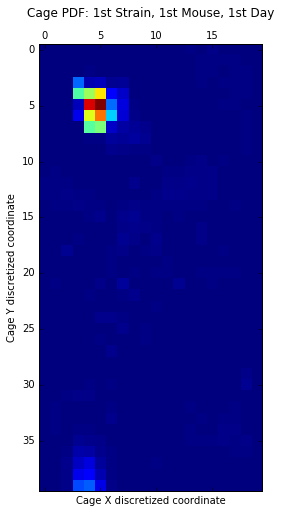

In [6]:
import matplotlib.pyplot as plt
##################################
# (3) Make position density first mouse first day
##################################
CT = np.load('data/txy_coords/CT/CT_strain0_mouse0_day0.npy')
CX = np.load('data/txy_coords/CX/CX_strain0_mouse0_day0.npy')
CY = np.load('data/txy_coords/CY/CY_strain0_mouse0_day0.npy')
# mask for HB Move Events
CT_NHB = np.load('data/txy_coords/C_idx_HB/C_idx_HB_strain0_mouse0_day0.npy')
CT_HB = ~ CT_NHB

start_time, stop_time = np.load('data/txy_coords/recordingStartTimeEndTime/recordingStartTimeEndTime_strain0_mouse0_day0.npy')

# Cage boundaries
YLower = 1.0; YUpper = 43.0; XUpper = 3.75; XLower = -16.25
xbins = 20; ybins = 40
M = np.vstack([CT, CX, CY])
pos_subset = pull_locom_tseries_subset(M, start_time, stop_time)
bin_times = total_time_rectangle_bins(pos_subset, xlims=(XLower, XUpper), ylims=(YLower, YUpper), xbins=xbins, ybins=ybins)
position_pdf = bin_times / bin_times.sum()

plt.matshow(position_pdf)
plt.title('Cage PDF: 1st Strain, 1st Mouse, 1st Day')
plt.xlabel('Cage X discretized coordinate')
plt.ylabel('Cage Y discretized coordinate')



In [7]:
# path definition
# nest-nest path model: all path should start from the nest and end at the nest
n = len(CT_HB)
start_ind = CT_HB[:n-1] * ( 1 - CT_HB[1:])
end_ind = ( 1 - CT_HB[:n-1] ) * CT_HB[1:]
start = [i for i in range(len(start_ind)) if start_ind[i]]
end = [i+2 for i in range(len(end_ind)) if end_ind[i]]

In [8]:
path_info = [[start[i], end[i]] for i in range(len(start))]

In [9]:
# the number of the path: 152
len(path_info), path_info[:5]

(152, [[26, 294], [304, 657], [668, 749], [797, 963], [1109, 1187]])

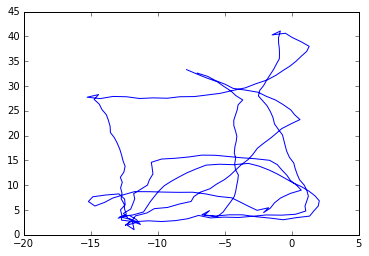

In [12]:
# first path plot
plt.plot(CX[path_info[0][0]:path_info[0][1]], CY[path_info[0][0]:path_info[0][1]])

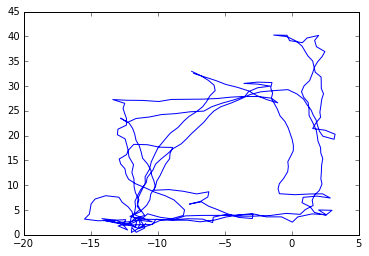

In [13]:
# second path
plt.plot(CX[path_info[1][0]:path_info[1][1]], CY[path_info[1][0]:path_info[1][1]])

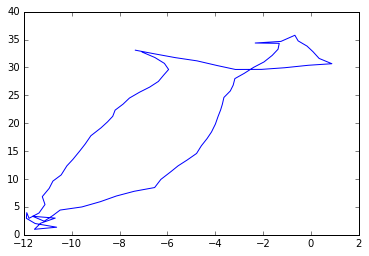

In [14]:
# third path
plt.plot(CX[path_info[2][0]:path_info[2][1]], CY[path_info[2][0]:path_info[2][1]])

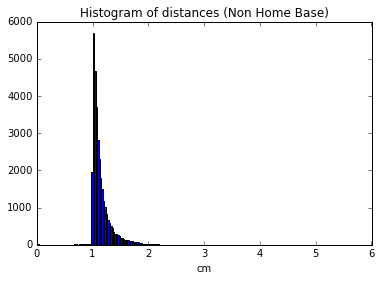

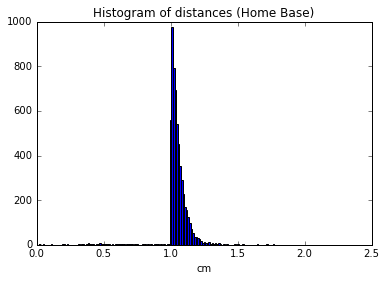

In [16]:
##################################
# (4) plot Move events; distance distribution
##################################
distances_btwn_events_HB = np.sqrt((CX[CT_HB][1:] - CX[CT_HB][:-1]) ** 2 + (CY[CT_HB][1:] - CY[CT_HB][:-1]) ** 2) [1 : -1]
distances_btwn_events_NHB = np.sqrt((CX[CT_NHB][1:] - CX[CT_NHB][:-1]) ** 2 + (CY[CT_NHB][1:] - CY[CT_NHB][:-1]) ** 2)

plt.figure()
plt.hist(distances_btwn_events_NHB, 200)
plt.title('Histogram of distances (Non Home Base)')
plt.xlabel('cm')

plt.figure()
plt.hist(distances_btwn_events_HB, 200)
plt.title('Histogram of distances (Home Base)')
plt.xlabel('cm')
plt.show()
